In [37]:
import sklearn
import numpy as np
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

Mimic III demo data from MIT will be used for this project. The database was loaded/built into postgreSQL for querying of needed data. The queried data was then exported to a .csv file for import into a python IDE. This data will be used to train a Random Forest Classifier for mortality prediction.

In [ ]:
mimic_csv_filepath = 'C:/Users/Mrman/OneDrive/Documents/sqlCSV/querydatapyth.csv'

mimic_df = pd.read_csv(mimic_csv_filepath, low_memory=False)

mimic_df.head()

Cleaning of data to remove missing values from data frame as well as convert date columns to datetime format for easier readability.

In [48]:
#conversion of date data to datetime formatting
mimic_df['dob'] = pd.to_datetime(mimic_df['dob'])
mimic_df['admittime'] = pd.to_datetime(mimic_df['admittime'])
mimic_df['dischtime'] = pd.to_datetime(mimic_df['dischtime'])
mimic_df['deathtime'] = pd.to_datetime(mimic_df['deathtime'])
mimic_df['charttime'] = pd.to_datetime(mimic_df['charttime'])

#removal of n/a, missing values
mimic_df.dropna()

,subject_id,dob,hadm_id,admittime,dischtime,deathtime,hospital_expire_flag,charttime,itemid,value,valuenum,valueuom,admittime_year,dob_year,age_at_admission,gender_F,gender_M,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT
920,10011,2090-06-05,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,1,2126-08-14 23:00:00,8441,49,49.0,mmHg,2126,2090,36,True,False,False,True,False
921,10011,2090-06-05,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,1,2126-08-14 23:00:00,211,81,81.0,BPM,2126,2090,36,True,False,False,True,False
922,10011,2090-06-05,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,1,2126-08-14 23:00:00,455,103,103.0,mmHg,2126,2090,36,True,False,False,True,False
924,10011,2090-06-05,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,1,2126-08-14 23:00:00,646,100,100.0,%,2126,2090,36,True,False,False,True,False
925,10011,2090-06-05,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,1,2126-08-14 23:00:00,456,67,67.0,mmHg,2126,2090,36,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696016,44154,1878-05-14,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,2178-05-15 09:45:00,1,2178-05-15 09:20:00,220050,60,60.0,mmHg,2178,1878,300,False,True,False,True,False
696017,44154,1878-05-14,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,2178-05-15 09:45:00,1,2178-05-15 09:20:00,220051,38,38.0,mmHg,2178,1878,300,False,True,False,True,False
696018,44154,1878-05-14,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,2178-05-15 09:45:00,1,2178-05-15 09:20:00,220052,45,45.0,mmHg,2178,1878,300,False,True,False,True,False
696019,44154,1878-05-14,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,2178-05-15 09:45:00,1,2178-05-15 09:20:00,220210,17,17.0,insp/min,2178,1878,300,False,True,False,True,False


Data cleaning as well as new features that are created for potentially better prediction of mortality in ICU scenarios.

In [28]:
# create new variables for birth and admit year to reduce calcualtion load
mimic_df['admittime_year'] = mimic_df['admittime'].dt.year
mimic_df['dob_year'] = mimic_df['dob'].dt.year

# Calculate age at admission
mimic_df['age_at_admission'] = mimic_df['admittime_year'] - mimic_df['dob_year']

# Encoding categorical data into numerical format for ML algorithm
mimic_df = pd.get_dummies(mimic_df, columns=['gender', 'admission_type',])

A random Forest classifier will be used to test various features against ICU mortality. This will provide information on the importance of each tested feature in comparison to one another and will allow for accuracy confirmation as well as modeling of importance.

In [49]:
#clean data for unrealistic values
clean_mimic_df = mimic_df[mimic_df['age_at_admission']<=120] #setting threshold for maximum age

# Define features (X) and target variable (y)
features = ['age_at_admission','gender_M', 'gender_F', 'admission_type_EMERGENCY', 'admission_type_URGENT', 'admission_type_ELECTIVE']
X = clean_mimic_df[features]
y = clean_mimic_df['hospital_expire_flag']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9467587694449943

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     80583
           1       0.95      0.93      0.94     65920

    accuracy                           0.95    146503
   macro avg       0.95      0.95      0.95    146503
weighted avg       0.95      0.95      0.95    146503



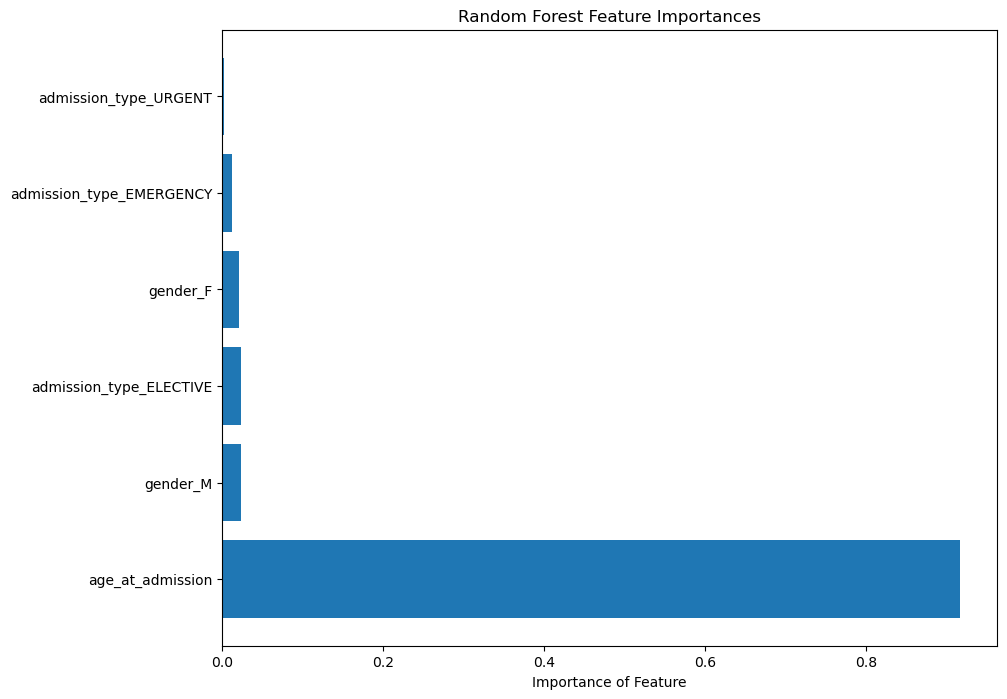

In [50]:
importance_of_features = model.feature_importances_
features = X.columns

indices = np.argsort(importance_of_features)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = importance_of_features[indices]

#plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Importance of Feature')
plt.title('Random Forest Feature Importances')
plt.show()

The model suggests that age at admission plays a crucial role in regards to mortality prediction in the ICU. The model had a reported accuracy of 94.68% indicating that the model was conducting accurate predictions for both true and false flags of mortality. The F1 score for both tests cases was relatively high indicating equal performance for each. Other than age, the other features (gender and admission type) have far less of an impact on mortality outcome in comparison. Other features such as vitals may have better comparison value in future modeling.